In [1]:
import pandas as pd
import os

current_path = os.getcwd()

train_file = os.path.join(current_path, "data/train")  # 训练集文件夹
val_file = os.path.join(current_path, "data/val")  # 验证集文件夹

train_audio = os.path.join(train_file, "audio_train")  # 训练集音频文件夹
val_audio = os.path.join(val_file, "audio_val")  # 验证集音频文件夹

train_scale_file = os.path.join(train_file, "audio_scale_train.xlsx")  # 训练集音频标签文件
val_scale_file = os.path.join(val_file, "audio_scale_val.xlsx")  # 验证集音频标签文件

feature_file = os.path.join(current_path, "features")  # 特征文件夹

saved_model_file = os.path.join(current_path, "saved_model/best.pth")  # 保存模型文件

{'ComParE_2016': <FeatureSet.ComParE_2016: 'compare/ComParE_2016'>,  
'GeMAPS': <FeatureSet.GeMAPS: 'gemaps/v01a/GeMAPSv01a'>,  
'GeMAPSv01a': <FeatureSet.GeMAPS: 'gemaps/v01a/GeMAPSv01a'>,  
'GeMAPSv01b': <FeatureSet.GeMAPSv01b: 'gemaps/v01b/GeMAPSv01b'>,  
'eGeMAPS': <FeatureSet.eGeMAPS: 'egemaps/v01a/eGeMAPSv01a'>,  
'eGeMAPSv01a': <FeatureSet.eGeMAPS: 'egemaps/v01a/eGeMAPSv01a'>,  
'eGeMAPSv01b': <FeatureSet.eGeMAPSv01b: 'egemaps/v01b/eGeMAPSv01b'>,  
'eGeMAPSv02': <FeatureSet.eGeMAPSv02: 'egemaps/v02/eGeMAPSv02'>,  
'emobase': <FeatureSet.emobase: 'emobase/emobase'>} 

['ComParE_2016', 
'GeMAPS', 
'GeMAPSv01b', 
'__class__', '__doc__', '__members__', '__module__', 
'eGeMAPS', 
'eGeMAPSv01b', 
'eGeMAPSv02', 
'emobase']

{'LowLevelDescriptors': <FeatureLevel.LowLevelDescriptors: 'lld'>, 
'LowLevelDescriptors_Deltas': <FeatureLevel.LowLevelDescriptors_Deltas: 'lld_de'>, 
'Functionals': <FeatureLevel.Functionals: 'func'>}

['Functionals', 'LowLevelDescriptors', 'LowLevelDescriptors_Deltas', '__class__', '__doc__', '__members__', '__module__']

In [2]:
import opensmile

# 提取音频特征
def extract_audio_feature(input_file, feature_file, mode):
    wav_vad_files = os.listdir(input_file)

    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    if mode == "train":
        ComParE_2016_Functionals_feature_path = os.path.join(feature_file, "ComParE_2016_Functionals_train_features.csv")
    elif mode == "val":
        ComParE_2016_Functionals_feature_path = os.path.join(feature_file, "ComParE_2016_Functionals_val_features.csv")


    count = 0
    for wav_vad in wav_vad_files:
        wav_vad_path = os.path.join(input_file, wav_vad)
        # print(wav_vad_path)
        feature = smile.process_file(wav_vad_path)
        
        if count == 0:
            feature.to_csv(ComParE_2016_Functionals_feature_path, mode='a', index=False)
        else:
            feature.to_csv(ComParE_2016_Functionals_feature_path, mode='a', header=False, index=False)
        count += 1

# extract_audio_feature(input_file=train_audio, feature_file=feature_file, mode="train")
# extract_audio_feature(input_file=val_audio, feature_file=feature_file, mode="val")

In [3]:
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, feature_file, label_file, scaler=None, transform=None):
        self.feature_file = feature_file
        self.label_file = label_file
        self.scaler = scaler
        self.labels = self.load_annotations()
        self.features = self.load_features()
        self.transform = transform

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        if self.transform:
            feature = self.transform(feature)
        return feature, label

    def load_annotations(self):
        df = pd.read_excel(self.label_file)

        # 提取特定的列，比如列名为 'column_name'
        column1 = df['量表完成时间']
        column2 = df['联系电话']
        column3 = df['抑郁得分']

        # 将两列数据拼接在一起
        concatenated_columns = pd.concat([column1, column2, column3], axis=1)

        audio_name = []
        labels = []
        for index, row in concatenated_columns.iterrows():
            audio_name.append(str(row['联系电话']) + '_' + row['量表完成时间'].replace('-', '_') + '.amr')
            labels.append(row['抑郁得分'])
        return labels
    
    def load_features(self):
        # 读取 CSV 文件
        df = pd.read_csv(self.feature_file)
        scaled_features = self.scaler.transform(df)  # 对数据进行标准化

        # 将每一行作为一个列表
        rows_as_lists = scaled_features.tolist()  #scledr之后

        return rows_as_lists


In [4]:
# 设置transforms来对数据集进行预处理

# from torchvision import transforms

# data_transforms = {
#     'train':
#         transforms.ToTensor(),
#     'valid': 
#         transforms.ToTensor()
# }

In [5]:
from sklearn.preprocessing import StandardScaler

features = pd.read_csv(os.path.join(feature_file, "significant_train_feature_151.csv"))

scaler = StandardScaler()
scaler.fit(features)

StandardScaler()

In [6]:
train_dataset = AudioDataset(feature_file=os.path.join(feature_file, "significant_train_feature_151.csv"), 
                             label_file=train_scale_file, 
                             scaler=scaler)
val_dataset = AudioDataset(feature_file=os.path.join(feature_file, "significant_val_feature_151.csv"), 
                           label_file=val_scale_file, 
                           scaler=scaler)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

len(train_loader), len(val_loader)

(23, 8)

In [7]:
import torch

for inputs, labels in train_loader:
    inputs = torch.stack(inputs, dim=1, out=None).squeeze(0).float()
    print('Feature is: {}'.format(inputs))
    print('Label is: {}'.format(labels))
    break

Feature is: tensor([[-1.2550e+00, -9.8499e-01, -1.3982e+00, -1.0082e+00, -1.1866e+00,
         -5.7844e-01, -1.1667e+00, -1.8967e+00, -1.3405e+00, -9.7721e-01,
         -2.1553e-01, -1.7988e+00, -1.3515e+00, -8.1965e-01, -1.6531e-01,
         -1.0051e-01, -6.1138e-01, -1.7800e+00, -1.3297e+00, -7.7631e-01,
         -7.9496e-02, -6.0006e-01, -1.7568e+00, -1.2908e+00, -7.4372e-01,
         -5.5931e-02, -1.7486e+00, -1.2801e+00, -7.3663e-01, -5.8409e-02,
         -1.3330e+00, -2.8040e+00, -1.3306e+00, -1.8971e-01, -8.4803e-01,
         -9.2752e-01, -1.1042e+00, -7.0126e-01, -9.3464e-01, -3.6860e-01,
         -9.7969e-01, -7.8861e-01, -3.9511e-01, -7.8734e-01, -1.2669e+00,
         -9.8605e-01,  3.5915e+00,  2.5036e+00, -9.5371e-01,  3.9120e+00,
          2.4967e+00, -9.3762e-01,  2.4824e+00, -9.1646e-01,  3.7318e+00,
          2.6028e+00,  3.2506e+00, -3.0065e+00, -7.0293e-01, -1.1918e+00,
          1.1271e+00, -5.9438e-01,  1.6120e+00,  1.3791e+00, -1.2611e-01,
         -6.6182e-01, -1.0

In [8]:
dataloaders = {'train':train_loader,'valid':val_loader}

# 是否用GPU训练
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is available!  Training on GPU ...


In [9]:
import torch.nn as nn

class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.layer1 = nn.Linear(151, 151)
        self.layer2 = nn.Linear(151, 64)
        self.layer3 = nn.Linear(64, 64)
        self.layer4 = nn.Linear(64, 32)
        self.layer5 = nn.Linear(32, 32)
        self.layer6 = nn.Linear(32, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer4(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer5(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer6(x)

        return x

# 实例化模型
model = ANNModel()

In [10]:
from torchsummary import summary

summary(model=model, input_size=(151,), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 151]          22,952
              ReLU-2                  [-1, 151]               0
           Dropout-3                  [-1, 151]               0
            Linear-4                   [-1, 64]           9,728
              ReLU-5                   [-1, 64]               0
           Dropout-6                   [-1, 64]               0
            Linear-7                   [-1, 64]           4,160
              ReLU-8                   [-1, 64]               0
           Dropout-9                   [-1, 64]               0
           Linear-10                   [-1, 32]           2,080
             ReLU-11                   [-1, 32]               0
          Dropout-12                   [-1, 32]               0
           Linear-13                   [-1, 32]           1,056
             ReLU-14                   

| Layer (type) | Output Shape | Param # |
|--------------|--------------|---------|
| Linear-1     | [-1, 151]    | 22,952  |
| ReLU-2       | [-1, 151]    | 0       |
| Dropout-3    | [-1, 151]    | 0       |
| Linear-4     | [-1, 64]     | 9,728   |
| ReLU-5       | [-1, 64]     | 0       |
| Dropout-6    | [-1, 64]     | 0       |
| Linear-7     | [-1, 64]     | 4,160   |
| ReLU-8       | [-1, 64]     | 0       |
| Dropout-9    | [-1, 64]     | 0       |
| Linear-10    | [-1, 32]     | 2,080   |
| ReLU-11      | [-1, 32]     | 0       |
| Dropout-12   | [-1, 32]     | 0       |
| Linear-13    | [-1, 32]     | 1,056   |
| ReLU-14      | [-1, 32]     | 0       |
| Dropout-15   | [-1, 32]     | 0       |
| Linear-16    | [-1, 1]      | 33      |
|--------------|--------------|---------|
| **Total params:**          |         | **40,009** |
| **Trainable params:**      |         | **40,009** |
| **Non-trainable params:**  |         | **0**      |
|--------------|--------------|---------|
| **Input size (MB):**       |         | **0.00**   |
| **Forward/backward pass size (MB):** | | **0.01**   |
| **Params size (MB):**      |         | **0.15**   |
| **Estimated Total Size (MB):**       | | **0.16**   |

In [11]:
import torch.optim as optim

# 优化器设置
# optimizer = optim.Adam(model.parameters(), lr=0.0005)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)  # 学习率每50个epoch衰减成原来的1/10

criterion = nn.MSELoss()
# criterion = nn.BCELoss()

In [12]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=50, filename='best.pth'):
    since = time.time()
    best_mae = 999
    model.to(device)

    val_mae_history = []
    train_mae_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]

    best_model_wts = copy.deepcopy(model.state_dict())

    mae = nn.L1Loss()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证

            running_loss = 0.0
            running_mae_loss = 0.0

            # 把数据都取个遍
            for inputs, labels in dataloaders[phase]:
                inputs = torch.stack(inputs, dim=1, out=None).squeeze(0).float()
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs.float(), labels.float())
                    mae_loss = mae(outputs.float(), labels.float())

                    # 训练阶段更新权重
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)
                running_mae_loss += mae_loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            mae_epoch_loss = running_mae_loss / len(dataloaders[phase].dataset)
            
            
            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} MAE: {:.4f}'.format(phase, epoch_loss, mae_epoch_loss))
            

            # 得到最好那次的模型
            if phase == 'valid' and mae_epoch_loss < best_mae:
                best_mae = mae_epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  'state_dict': model.state_dict(),  # 字典里key就是各层的名字，值就是训练好的权重
                  'best_mae': best_mae,
                  'optimizer' : optimizer.state_dict(),  # 优化器的状态信息
                }
                torch.save(state, filename)

                # 计算结果
                model_preds = []
                true_labels = []
                for inputs, labels in dataloaders['valid']:
                    inputs = torch.stack(inputs, dim=1, out=None).squeeze(0).float()
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    with torch.no_grad():
                        outputs = model(inputs)
                        model_preds.extend(outputs)
                        true_labels.extend(labels)
                        # print('labels', labels.cpu())
                        # print('outputs', outputs.cpu())
                val_model_preds = model_preds
                val_true_labels = true_labels

                model_preds = []
                true_labels = []
                for inputs, labels in dataloaders['train']:
                    inputs = torch.stack(inputs, dim=1, out=None).squeeze(0).float()
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    with torch.no_grad():
                        outputs = model(inputs)
                        model_preds.extend(outputs)
                        true_labels.extend(labels)
                        # print('labels', labels.cpu())
                        # print('outputs', outputs.cpu())
                train_model_preds = model_preds
                train_true_labels = true_labels
                

            if phase == 'valid':
                val_mae_history.append(mae_epoch_loss)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)  # 学习率衰减
            if phase == 'train':
                train_mae_history.append(mae_epoch_loss)
                train_losses.append(epoch_loss)
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Mae: {:4f}'.format(best_mae))

    # 训练完后用最好的一次当做模型最终的结果,等着一会测试
    model.load_state_dict(best_model_wts)
    return model, val_mae_history, train_mae_history, valid_losses, train_losses, LRs, val_model_preds, val_true_labels, train_model_preds, train_true_labels

In [13]:
model_ft, val_mae_history, train_mae_history, valid_losses, train_losses, LRs, val_model_preds, val_true_labels, train_model_preds, train_true_labels  = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=300, filename=saved_model_file)

Epoch 0/299
----------


d:\miniconda3\envs\speech_Depression\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\miniconda3\envs\speech_Depression\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Time elapsed 0m 0s
train Loss: 42.4928 MAE: 5.5089
Time elapsed 0m 0s
valid Loss: 53.1020 MAE: 5.2182
Optimizer learning rate : 0.0001000

Epoch 1/299
----------


d:\miniconda3\envs\speech_Depression\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\miniconda3\envs\speech_Depression\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
d:\miniconda3\envs\speech_Depression\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoc

Time elapsed 0m 1s
train Loss: 41.6409 MAE: 5.4452
Time elapsed 0m 1s
valid Loss: 52.9590 MAE: 5.2103
Optimizer learning rate : 0.0001000

Epoch 2/299
----------
Time elapsed 0m 1s
train Loss: 41.3519 MAE: 5.4239
Time elapsed 0m 1s
valid Loss: 52.7618 MAE: 5.1999
Optimizer learning rate : 0.0001000

Epoch 3/299
----------
Time elapsed 0m 1s
train Loss: 40.9669 MAE: 5.3989
Time elapsed 0m 1s
valid Loss: 52.5448 MAE: 5.1901
Optimizer learning rate : 0.0001000

Epoch 4/299
----------
Time elapsed 0m 1s
train Loss: 41.0835 MAE: 5.4078
Time elapsed 0m 1s
valid Loss: 52.3405 MAE: 5.1778
Optimizer learning rate : 0.0001000

Epoch 5/299
----------
Time elapsed 0m 1s
train Loss: 40.6030 MAE: 5.3664
Time elapsed 0m 1s
valid Loss: 52.0140 MAE: 5.1669
Optimizer learning rate : 0.0001000

Epoch 6/299
----------
Time elapsed 0m 2s
train Loss: 40.3240 MAE: 5.3559
Time elapsed 0m 2s
valid Loss: 51.7681 MAE: 5.1471
Optimizer learning rate : 0.0001000

Epoch 7/299
----------
Time elapsed 0m 2s
train Los

In [14]:
val_model_preds = [t.item() for t in val_model_preds]
val_true_labels = [t.item() for t in val_true_labels]

train_model_preds = [t.item() for t in train_model_preds]
train_true_labels = [t.item() for t in train_true_labels]

In [15]:
import scipy.stats

# 计算皮尔逊相关系数
correlation, p_value = scipy.stats.pearsonr(val_model_preds, val_true_labels)

print(f"皮尔逊相关系数: {correlation}")
print(f"p-value: {p_value}")

皮尔逊相关系数: 0.7365578196573936
p-value: 3.4755600759489818e-06


In [16]:
import matplotlib.pyplot as plt

def plot_mae_curve(train_history, val_history):

    epochs = range(1, len(train_history) + 1)
    
    # 绘制训练集和验证集的 结果 曲线
    plt.plot(epochs, train_history, label='Training MAE')
    plt.plot(epochs, val_history, label='Validation MAE')
    
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title('Training and Validation MAE Curve over Epochs')
    plt.legend()
    plt.show()

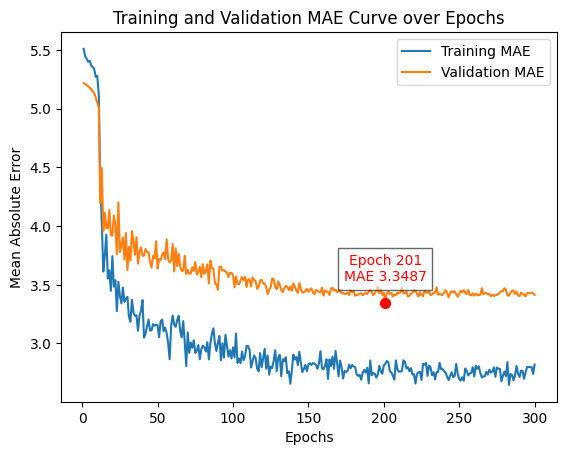

In [17]:
import matplotlib.pyplot as plt

def plot_mae_curve(train_history, val_history):
    epochs = range(1, len(train_history) + 1)
    
    # 绘制训练集和验证集的 MAE 曲线
    plt.plot(epochs, train_history, label='Training MAE')
    plt.plot(epochs, val_history, label='Validation MAE')
    
    # 找到 val_history 中的最小值及其对应的索引（即 epoch）
    min_val_mae = min(val_history)
    min_val_epoch = val_history.index(min_val_mae) + 1
    
    # 在最小值处标注 epoch 和 MAE 值
    plt.scatter(min_val_epoch, min_val_mae, color='red', s=50, zorder=5)
    
    # 计算标注文本的位置，避免挡住曲线
    offset = 0.05 * (plt.ylim()[1] - plt.ylim()[0])  # 根据 y 轴范围计算一个偏移量
    plt.text(min_val_epoch, min_val_mae + offset, f'Epoch {min_val_epoch}\nMAE {min_val_mae:.4f}', 
             ha='center', va='bottom', fontsize=10, color='red', bbox=dict(facecolor='white', alpha=0.6))
    
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title('Training and Validation MAE Curve over Epochs')
    plt.legend()
    plt.show()

plot_mae_curve(train_mae_history, val_mae_history)


In [18]:
# # 结果保存
# import csv

# filename = r'D:\Projects\Speech_Depression\Results\ComParE_3.417_500_Adam_1e-3_\train_losses.csv'
# data = [train_losses]
# # 将列表写入CSV文件
# with open(filename, 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerows(data)

# 模型测试

In [19]:
checkpoint = torch.load(r'D:\Projects\Speech_Depression\saved_model\best.pth')
model.load_state_dict(checkpoint['state_dict'])

for inputs, labels in val_loader:
    inputs = torch.stack(inputs, dim=1, out=None).squeeze(0).float()
    # print('Input is: {}'.format(inputs))
    print('Label is: {}'.format(labels))

    model.eval()

    if train_on_gpu:
        output = model(inputs.cuda())
    else:
        output = model(inputs)

    print('Output is: {}'.format(output))

    break

Label is: tensor([5, 1, 0, 0])
Output is: tensor([[4.8289],
        [4.8885],
        [4.8817],
        [5.0232]], device='cuda:0', grad_fn=<AddmmBackward0>)
